In [65]:
import gym, os
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import torchvision.transforms as T

import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("Pong-v0")

state_space = env.observation_space.shape[0]
print(env.observation_space.shape)
action_space = env.action_space.n
print(action_space)

print(device)

(210, 160, 3)
6
cpu


Helper function

In [76]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000000

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def get_screen(x):
    x = np.array(x)
    screen = x.transpose((2,0,1)) #(height,width,num_frames) -> (num_frames,heigth,width)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

Creating two seperate networks the actor and the critic

In [77]:
hidden_size = 480
num_frames = 3
end_out = 4


class Actor(nn.Module):
    def __init__(self, h, w, outputs):
        super(Actor, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 4, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(4, 4, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(4)
        self.conv3 = nn.Conv2d(4, end_out, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(end_out)
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * end_out
        self.out = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        return self.out(x.view(x.size(0), -1))

In [78]:
class Critic(nn.Module):
    def __init__(self, h, w, outputs):
        super(Critic, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 4, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(4, 4, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(4)
        self.conv3 = nn.Conv2d(4, end_out, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(end_out)
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * end_out
        self.out = nn.Linear(linear_input_size, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        return self.out(x.view(x.size(0), -1))

In [75]:
learn_rate = 0.0001
n_iters = 5
avg_over = 1

init_screen = get_screen(env.reset())
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

actor = Actor(screen_height, screen_width, n_actions).to(device)
critic = Critic(screen_height, screen_width, n_actions).to(device)

optimizerA = optim.Adam(actor.parameters(), lr=learn_rate)
optimizerC = optim.Adam(critic.parameters(), lr=learn_rate)

score_avg = []
score_avg_all = []

for iter in range(n_iters):
    state = get_screen(env.reset())
    log_probs = []
    values = []
    rewards = []
    masks = []
    entropy = 0
    env.reset()
    reward_sum = 0

    for i in count():
        #env.render()
        state = torch.FloatTensor(state).to(device)
        dist, value = actor(state), critic(state)
        
        action = dist.sample()
        next_state, reward, done, _ = env.step(action.cpu().numpy())
        next_state = get_screen(next_state)
        
        reward_sum += reward
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
        masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

        state = next_state

        if done:
            #print('Iteration: {}, Score: {}'.format(iter, i))
            score_avg.append(reward_sum)
            break
    
    if iter % avg_over == 0 and iter != 0:
        score_sum = 0
        for i in range(0,avg_over-1):
            score_sum += score_avg[i]
            n = i
        score_sum = score_sum/n
        print('Iteration: {}, Score avg: {}'.format(iter, score_sum))
        score_avg_all.append(score_sum)
        score_avg.clear()
        
    
    next_state = torch.FloatTensor(next_state).to(device)
    next_value = critic(next_state)
    returns = compute_returns(next_value, rewards, masks)

    log_probs = torch.cat(log_probs)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)

    advantage = returns - values

    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    optimizerA.zero_grad()
    optimizerC.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    optimizerA.step()
    optimizerC.step()

AttributeError: 'Tensor' object has no attribute 'sample'

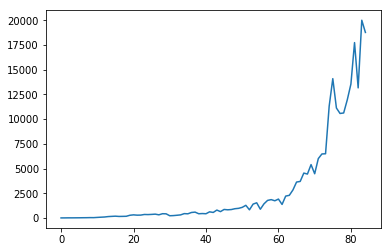

In [6]:
plt.plot(score_avg_all)

In [ ]:
torch.save(actor, 'results/actor.pkl')
torch.save(critic, 'results/critic.pkl')
env.close()